# School location choice model 

There are 4 models that should run in sequentially. 

- Public vs private school 
- Public school choice model 
- Private school choice model 
- TOD model (Randon sample from a 2-d kernel distribution) 

In [1]:
import numpy as np
import pandas as pd
import orca
from matplotlib import pyplot as plt
import matplotlib.animation as animation
# import seaborn as sns
import os; os.chdir('../../')
import warnings; warnings.simplefilter('ignore')

import pandana as pdna
from collections import OrderedDict
import pylogit as pl
from pylogit import nested_logit as nl
import math 
import pickle
import dill
import time
import random
import scipy.stats as st
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
    
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim_templates.models import BinaryLogitStep
from urbansim.utils import misc
import urbansim_templates

from scripts import datasources, models, variables, utils

Registering model step 'TOD_choice'
Registering model step 'auto_ownership'
Registering model step 'WLCM_gen_tt'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'
Registering model step 'Public_vs_private'


In [2]:
def f1_scores(probs, y_test):
    
    results_table = pd.DataFrame(probs, columns= ['private', 'public'], index = y_test.index)
    results_table['real'] = np.array(y_test)
    
    TPR_list = []
    FPR_list = []
    F1_score_list = []
    MMC_score_list = []
    for x in np.linspace(0,1,100):
        results_table['predicted'] = (results_table.public > x)*1
        results_table['tp'] = (results_table.real == 1) & (results_table.predicted == 1)
        results_table['tn'] = (results_table.real == 0) & (results_table.predicted == 0)
        results_table['fp'] = (results_table.real == 0) & (results_table.predicted == 1)
        results_table['fn'] = (results_table.real == 1) & (results_table.predicted == 0)
    # print ((results_table.real == results_table.predicted).mean())
    # pd.crosstab( results_table.real, results_table.predicted)
        TP = results_table.tp.sum()
        TN = results_table.tn.sum()
        FP = results_table.fp.sum()
        FN = results_table.fn.sum()

        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        recall = TPR 
        precision = TP / (TP + FP)
        F1_score = 2*(precision*recall)/(precision+recall)
        MMC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

        TPR_list.append(TPR)
        FPR_list.append(FPR)
        F1_score_list.append(F1_score)
        MMC_score_list.append(MMC)
    
    return TPR_list, FPR_list, F1_score_list, MMC_score_list, results_table

In [3]:
input_file_format = 'csv'
input_data_dir = 's3://baus-data/spring_2019/'

formattable_fname_dict = {
    'parcels': 'parcels.{0}',
    'buildings': 'buildings.{0}',
    'jobs': 'jobs.{0}',
    'establishments': 'establishments.{0}',
    'households': 'households.{0}',
    'persons': 'persons.{0}',
    'rentals': 'craigslist.{0}',
    'units': 'units.{0}',
    'mtc_skims': 'mtc_skims.{0}',
    'beam_skims_raw': '30.skims-smart-23April2019-baseline.csv.gz',
    'beam_skims_imputed': 'beam_skims_imputed.{0}',
    # the following nodes and edges .csv's will be phased out and
    # replaced by travel model skims entirely
    'drive_nodes': 'drive_nodes.{0}',
    'drive_edges': 'drive_edges.{0}',
    'drive_access_vars': 'drive_net_vars.{0}',
    'walk_nodes': 'walk_nodes.{0}',
    'walk_edges': 'walk_edges.{0}',
    'walk_access_vars': 'walk_net_vars.{0}',
    'zones': 'zones.{0}',
    'zone_access_vars': 'zones_w_access_vars.{0}',
    'students_k12': 'students_k12.{0}',
    'schools_k12': 'schools_bay_area.{0}'
}

def format_fname_dict(formattable_fname_dict, format='csv'):
    formatted_dict = {
        k: v.format('csv')
        for k, v in formattable_fname_dict.items()}
    return formatted_dict

input_fnames = format_fname_dict(
            formattable_fname_dict, input_file_format)

In [4]:
orca.add_injectable('input_file_format', input_file_format)
orca.add_injectable('input_data_dir', input_data_dir)
orca.add_injectable('input_fnames', input_fnames)
orca.add_injectable('store', None)

In [5]:
orca.run(['initialize_network_small']) 
orca.run(['initialize_network_walk']) 
orca.run(['initialize_imputed_skims']) 
orca.run(['skims_aggregations']) 

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s
Running step 'initialize_imputed_skims'
Time to execute step 'initialize_imputed_skims': 78.69 s
Total time to execute iteration 1 with iteration value None: 78.69 s
Running step 'skims_aggregations'
Time to execute step 'skims_aggregations': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [6]:
# Distance-based accesibilities 
#SAVED TO DISK AS THEY TAKE A LONG TIME TO RUN. 

# orca.run(['network_aggregations_small']) 
# orca.run(['network_aggregations_walk']) 
# nodessmall = orca.get_table('nodessmall').to_frame()
# nodeswalk = orca.get_table('nodeswalk').to_frame()
# nodessmall.to_csv('/home/ubuntu/activitysynth/activitysynth/data/nodessmall.csv')
# nodeswalk.to_csv('/home/ubuntu/activitysynth/activitysynth/data/nodeswalk.csv')
# beam_skims_imputed.to_csv('/home/ubuntu/activitysynth/activitysynth/data/beam_skims_imputed.csv')

## CHTS Data for estimation 

In [7]:
k12_students = pd.read_csv('s3://baus-data/spring_2019/students_k12.csv')

persons = pd.read_csv('s3://baus-data/fall_2018/chts_persons_w_zone_ids.csv')
households = pd.read_csv("s3://baus-data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")

zones = orca.get_table('zones').to_frame()

beam_skims = orca.get_table('beam_skims_imputed').to_frame().reset_index()
schools = orca.get_table('schools').to_frame()
public_schools_50 = orca.get_table('public_schools_50').to_frame()

#I have save this tables (Distance-based accessibilities) on disk just for convinience
nodessmall = pd.read_csv('/home/ubuntu/activitysynth/activitysynth/data/nodessmall.csv').set_index('osmid')
nodeswalk = pd.read_csv('/home/ubuntu/activitysynth/activitysynth/data/nodeswalk.csv').set_index('osmid')

orca.add_table('nodessmall', nodessmall)
orca.add_table('nodeswalk', nodeswalk)

In [8]:
counties_dic = {'06001': 1, '06013': 13, '06041': 41, 
                '06055': 55, '06075': 75, '06081': 81, 
                '06085': 85, '06095': 95, '06097': 97}

## Data cleaning

In [9]:
students = k12_students.copy(deep=True)

#Getting the type (public/private) of school for each observation
students = students.merge(schools.loc[:,['type']], how = 'left', left_on = 'school_id', right_index = True)
students['s_type'] = students.type.replace(['public', 'private'], [1,0])

#Filtering correct age 
students = students[students.AGE <= 18]

#Hispanic indicador
students.HISP.replace([2,9,8], [0, np.nan, np.nan], inplace = True)

#Sex indicator 
students.GEND.replace(2,0, inplace = True) # 1 male, 0 female

#Cheking if there is more than one race per person
students['race'] = students.RACE1.notnull().astype(int) + \
                          students.RACE2.notnull().astype(int) + \
                          students.RACE3.notnull().astype(int) + \
                          students.RACE4.notnull().astype(int)


students['race'] = students['race'].replace(2, 6) # Two or more races (6. 2+ races)
students['race'] = np.where(students['race'] == 1, students['RACE1'], students['race'])

students.rename(columns = {'HISP': 'hispanic', 'AGE': 'age', 'GEND': 'sex'}, inplace = True)

###################################
#Merging household characteristics
###################################

#Getting number of children per household, race and age of the head (head assume to be PERNO == 1)
persons['children'] = (persons.AGE < 18).astype(int) # Children indicator
# persons.loc[:,['RACE1', 'RACE2', 'RACE3', 'RACE4', 'O_RACE']]
persons['race_id'] = persons.RACE1.notnull().astype(int) + \
                          persons.RACE2.notnull().astype(int) + \
                          persons.RACE3.notnull().astype(int) + \
                          persons.RACE4.notnull().astype(int)

persons['race_id'] = persons['race_id'].replace(2, 6) # Two or more races (6. 2+ races)
persons['race_id'] = np.where(persons['race_id'] == 1, persons['RACE1'], persons['race_id'])


hh_per_var = persons.loc[:,['SAMPN', 'PERNO', 'children','race_id', 'AGE', 'HISP']].sort_values(['SAMPN', 'PERNO']).groupby('SAMPN').\
             agg({'children': 'sum', 'race_id': 'first', 'AGE': 'first', 'HISP': 'first'})

hh_per_var.rename(columns = {'AGE': 'age_of_head', 'race_id': 'race_head', 'HISP': 'hispanic_head'}, inplace = True)
hh_per_var.hispanic_head.replace(2,0, inplace = True) # 1 is hispanic, 0 itherwise

students = students.merge(hh_per_var, how = 'inner', left_on = 'SAMPN', right_index = True )

#Merging household table
households['recent_mover'] = (households.TEN <= 5).astype(int)

#Naming varaibles as in PUMS varaibles
pums_names = {'HHSIZ': 'persons', 'INCOM': 'income', 'OWN': 'tenure', 'HHVEH': 'cars', 'HHEMP': 'workers' }
households.rename(columns=pums_names, inplace = True)

hh_var = ['SAMPN', 'persons', 'income', 'tenure', 'cars', 'workers', 'recent_mover']
students = students.merge(households.loc[:,hh_var], how = 'left', on = 'SAMPN')

################################
#Merging accesibility variables
################################

#Getting small and walk networks
netsmall = orca.get_injectable('netsmall')
netwalk = orca.get_injectable('netwalk')

#Getting small and walk node ID for each student home location
students['small_node_id'] = netsmall.get_node_ids(students.HXCORD.astype(float),students.HYCORD.astype(float))
students['walk_node_id'] = netwalk.get_node_ids(students.HXCORD.astype(float),students.HYCORD.astype(float))

#Merging distance based accesibilities
students = students.merge(nodessmall, how = 'left', left_on = 'small_node_id', right_index = True)
students = students.merge(nodeswalk, how = 'left', left_on = 'walk_node_id', right_index = True)

#Merging time-based accesibilities
students = students.merge(zones, how = 'left', left_on ='zone_id_home', right_index = True)

######################################################################
#Merging average score of xx closest schools to student home location 
######################################################################

df = public_schools_50.copy()
df.columns = df.columns.astype(str)

# Get the score of the 50th closest scools to node ID
for col in range(1,51):
    col_name = 'poi' + str(col)
    df = df.merge(schools[['rank']], how = 'left', left_on = col_name, right_index = True)
    new_col_name = 'rank' + str(col)
    df.rename(columns = {'rank': new_col_name}, inplace = True)

# Calculate average of the 50th closest scools to node ID
for col in range(102,151):
    col_name = 'mean' + str(col-100)
    df[col_name]= df.iloc[:,100:col].mean(axis = 1)

#Merging to student table 
students = students.merge(df.loc[:,df.columns.str.startswith('mean')], 
                          how = 'left', 
                          left_on = 'small_node_id',
                          right_index = True)

###############################
# ADDING INTERACTION VARIABLES 
###############################
students['tenure'].replace(2,0, inplace = True) # 1: own, 0:Rent
students['income:tenure'] = students['income'] * students['tenure']
students['income:recent_mover'] = students['income'] * students['recent_mover']
students['income:race'] = students['income'] * students['race']
students['income:hispanic'] = students['income'] * students['hispanic']
students['mean5:tenure'] = students['mean5'] * students['tenure']
students['mean5:cars'] = students['mean5'] * students['cars']

city_dummies = pd.get_dummies(students.HCITY)
city_dummies.columns = city_dummies.columns.str.replace(' ', '_')
city_dummies.rename(columns= lambda x: x.strip(), inplace = True)
students = pd.concat([students, city_dummies], axis=1, sort=False)


In [16]:
#Selecting important variables 
students_vars = ['SAMPN', 'PERNO', 's_type', 'age', 'race', 'hispanic', 'sex', 
                 'age_of_head', 
                 'race_head', 'hispanic_head', 'recent_mover', 'persons',
                 'income', 'tenure', 'cars', 'workers', 'children','mean2', 'mean5', 'mean6', 'mean7', 'mean8', 'mean9',
                 'mean10', 'mean11', 'mean12', 'mean13', 'mean14','mean15', 'mean20','income:tenure','income:recent_mover',
                 'income:race', 'income:hispanic', 'mean5:tenure', 'mean5:cars'] \
                 + list(nodessmall.columns) + list(nodeswalk.columns)  \
                 + list(zones.drop(columns = ['gid', 'area', 'acres']).columns) + list(city_dummies.columns)

students_df = students[students_vars]

In [11]:
#Selecting important variables 
students_vars = ['SAMPN', 'PERNO', 's_type', 'age', 'race', 'hispanic', 'sex', 
                 'age_of_head', 
                 'race_head', 'hispanic_head', 'recent_mover', 'persons',
                 'income', 'tenure', 'cars', 'workers', 'children'] \
                 + list(zones.drop(columns = ['gid', 'area', 'acres']).columns)

students_df = students[students_vars]

In [17]:
################################
# Dropping NA values 
################################
#Replacing NA keys to real na 
na_dict = {
    'race':[98, 99],
    'hispanic':[8, 9],
    'sex':[9],
    'income':[98,99],
    'tenure':[7, 8, 9],
    'race_head':[98, 99],
    'hispanic_head':[8, 9],
    'age_of_head': [998, 999],
    }

for col in na_dict:
    for vals in na_dict[col]:
        students_df[col] = students_df[col].replace(vals,np.nan)
        
students_df.dropna(inplace = True)
students_df.shape

(2996, 297)

In [18]:
#Race variable to dummy variables
race_dict = {1:'white', 2:'african_american',3:'indian/alaska',4:'asian', 5:'hawaii/pacific', 6:'+2races', 97:'other'}
students_df.race.replace(race_dict, inplace = True)
students_df.race_head.replace(race_dict, inplace = True)

race_dummies = pd.get_dummies(students_df.race, prefix='race', prefix_sep='_')
race_head_dummies = pd.get_dummies(students_df.race_head, prefix='race_head', prefix_sep='_')
students_df = pd.concat([students_df, race_dummies, race_head_dummies], axis=1, sort=False)


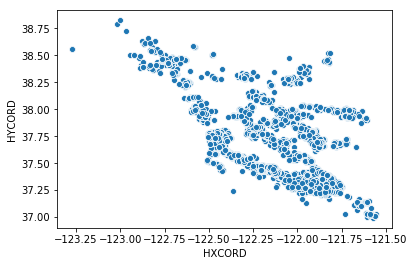

In [13]:
sns.scatterplot(students.HXCORD, students.HYCORD);

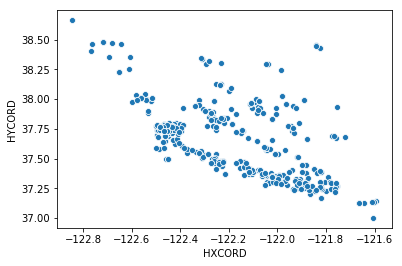

In [14]:
sns.scatterplot(students[students.s_type == 0].HXCORD, students[students.s_type == 0].HYCORD);

In [15]:
# sns.scatterplot(x='HXCORD', y='HYCORD', data = students[students.s_type == 0])#, hue = 's_type')

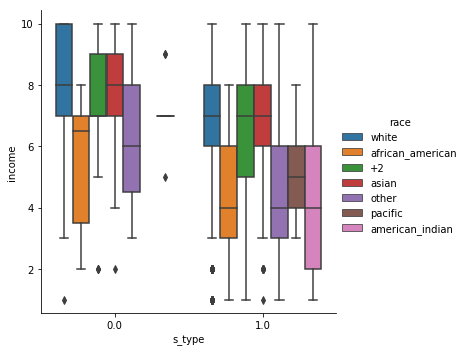

In [122]:
sns.catplot(x = 's_type', y = 'income', hue = 'race', data = students_df, kind = 'box');

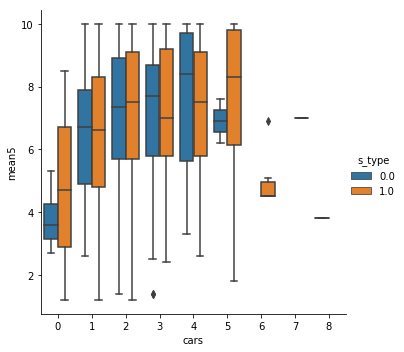

In [17]:
sns.catplot(x = 'cars', y = 'mean5', hue = 's_type', data = students_df, kind = 'box');

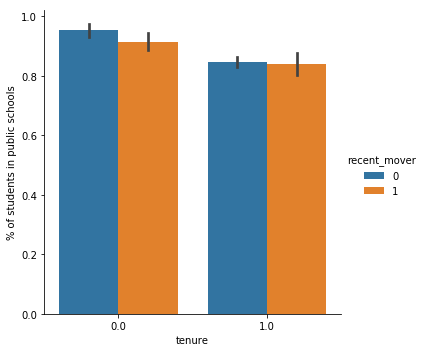

In [18]:
sns.catplot(x="tenure", y="s_type", kind="bar", hue = 'recent_mover',data=students_df)
plt.ylabel('% of students in public schools');

In [20]:
# fig, ax1 = plt.subplots(figsize=(10, 50))
# sns.catplot(students.s_type, students.HCITY, kind="bar", ax=ax1);

## ML Approach 



In [16]:
# Splitting train (70%) and test (30%) dataset
X = students_df.drop(columns=['SAMPN', 'PERNO', 's_type', 'race', 'race_head'])
y = students_df.s_type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Base line 
Assing all observations to class 1 (Public schools) 

In [19]:
y_base_line = np.ones(len(y_test))
accuracy_base_line = np.mean(y_base_line == y_test)
print ("Base line accuracy: ", accuracy_base_line)
pd.crosstab( y_test, y_base_line)#,normalize = 'index')

Base line accuracy:  0.8765294771968855


col_0,1.0
s_type,
0.0,111
1.0,788


### Decission tree 

In [86]:
# Max depth cross validation 
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 

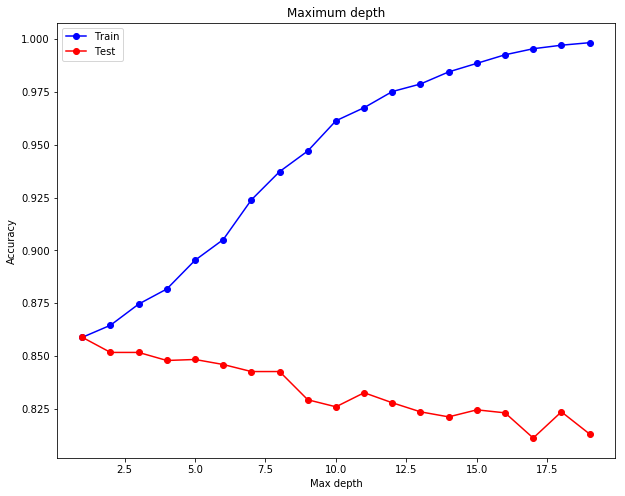

In [87]:
# Plotting max depth cross validation plot 
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

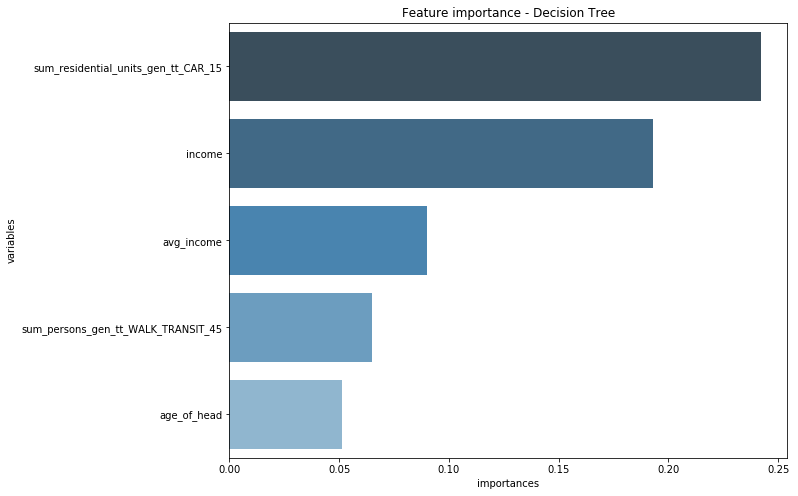

In [20]:
dtc = tree.DecisionTreeClassifier(criterion='entropy',max_depth= 5)
dtc.fit(X_train, y_train);

aa = pd.DataFrame({'importances':dtc.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=aa[:5],palette="Blues_d" )
plt.title('Feature importance - Decision Tree');

In [21]:
print ("Model accuracy: ", dtc.score(X_test, y_test))
pd.crosstab( y_test, dtc.predict(X_test))#,normalize = 'index')

Model accuracy:  0.8798665183537263


col_0,0.0,1.0
s_type,,
0.0,16,95
1.0,13,775


### Gradient boosting

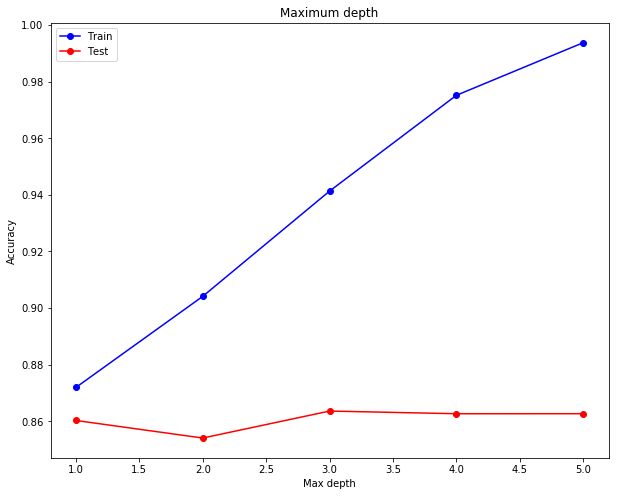

In [27]:
result_train = []
result_test = []
max_depth = range(1,6)
for i in max_depth:
    clf = GradientBoostingClassifier(max_depth = i, n_estimators = 100)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
    
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

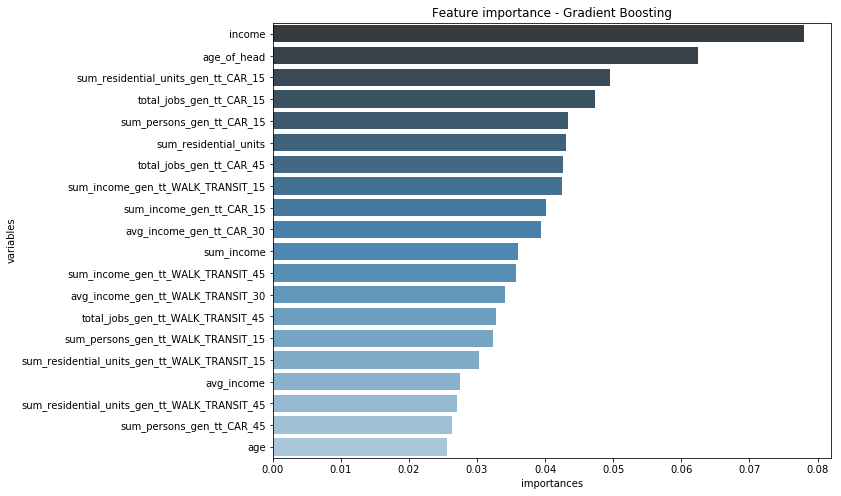

In [22]:
gbc = GradientBoostingClassifier(max_depth=4, n_estimators=100)
gbc.fit(X_train, y_train)

# importances = model.feature_importances_
# pd.crosstab( y_test, model.predict(X_test))
# model.score(X_test, y_test)

feat_importance = pd.DataFrame({'importances':gbc.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=feat_importance[:20],palette="Blues_d" )
plt.title('Feature importance - Gradient Boosting');

In [23]:
print ("Model accuracy: ", gbc.score(X_test, y_test))
pd.crosstab(y_test, gbc.predict(X_test))

Model accuracy:  0.8921023359288098


col_0,0.0,1.0
s_type,,
0.0,27,84
1.0,13,775


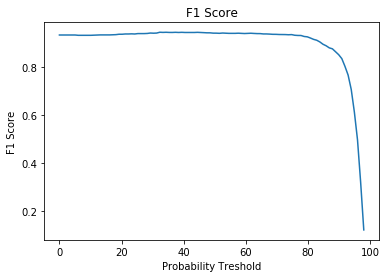

In [616]:
#f1 score plot 
probs = gbc.predict_proba(X_test)
TPR_list, FPR_list, F1_score_list, MMC_score_list, results_table = f1_scores(probs, y_test)

plt.plot( np.linspace(0,1,100)*100, F1_score_list,)
plt.xlabel('Probability Treshold');
plt.ylabel('F1 Score')
plt.title('F1 Score');

In [41]:
#Changing probability treshhold
results_table['predicted'] = (results_table.public > 0.85)*1

accuracy_gbc = np.mean(results_table['predicted'] == y_test)
print ("gbc accuracy: ", accuracy_gbc)
pd.crosstab(results_table.real, results_table.predicted)
# results_table.groupby('real').agg({'public':['mean', 'std']})

gbc accuracy:  0.8231368186874305


predicted,0,1
real,,
0.0,63,48
1.0,111,677


### AdaBost Classifier

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [612]:
# result_train = []
# result_test = []
# max_depth = range(1,100,10)
# for i in max_depth:
#     clf = AdaBoostClassifier(n_estimators=100, random_state=0)
#     scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
#     result_train.append(scores['train_score'].mean())
#     result_test.append(scores['test_score'].mean()) 
    
# plt.figure(figsize = (10,8))
# plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
# plt.plot(max_depth, result_test, '-o',color='red',label='Test')
# plt.xlabel('Max depth')
# plt.ylabel('Accuracy')
# plt.title('Maximum depth')
# plt.legend();

In [18]:
clf = AdaBoostClassifier(n_estimators=500, random_state=0)
clf.fit(X_train, y_train)

# feat_importance = pd.DataFrame({'importances':clf.feature_importances_,
#                    'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

# plt.figure(figsize = (10,8))
# ax = sns.barplot(x='importances', y='variables', data=feat_importance[:20],palette="Blues_d" )
# plt.title('Feature importance - Gradient Boosting');


print ("Model accuracy: ", clf.score(X_test, y_test))
pd.crosstab(y_test, clf.predict(X_test))

Model accuracy:  0.8676307007786429


col_0,0.0,1.0
s_type,,
0.0,25,86
1.0,33,755


In [694]:
#Creating a pkl file
file_Name = "configs/pu_vs_pr.pkl"
fileObject = open(file_Name,'wb') 
dill.dump(clf,fileObject)   
fileObject.close()

In [695]:
#Testing pkl file
fileObject = open(file_Name,'rb')  
# load the object from the file into var b
b = pickle.load(fileObject)  
b.predict(X_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [692]:
os.getcwd()

'/home/ubuntu/activitysynth/activitysynth'

In [ ]:
@orca.step()
def SLCM_simulate(persons):
    """
    Generate school location choices for the synthetic pop households.
    
    """
    #Running the simulation 
    file_Name = "configs/SLCM_gen_tt.pkl"
    fileObject = open(file_Name,'rb')  
    SLCM = pickle.load(fileObject) 
    orca.add_column('long_format', 'probabilities', SLCM.predict(orca.get_table('long_format').to_frame()))
    df = orca.get_table('long_format').to_frame()
    school_choice = df.sort_values("probabilities", ascending=False).groupby('obs_id').agg({'school_choice_set': 'first', 
                                                                                            'school_zone_id': 'first'})
    
    #Adding school choice to the persons table. 
    persons.update_col('school_id',school_choice.school_choice_set )
    persons.update_col('zone_id_school',school_choice.school_zone_id )

#### Gaussian Process Classifier

In [630]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [631]:
clf = GaussianProcessClassifier(1.0 * RBF(1.0))
clf.fit(X_train, y_train)

print ("Model accuracy: ", clf.score(X_test, y_test))
pd.crosstab(y_test, clf.predict(X_test))

Model accuracy:  0.7875417130144605


col_0,0.0,1.0
s_type,,
0.0,74,37
1.0,154,634


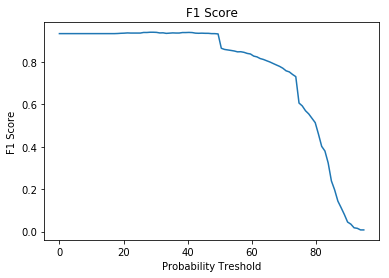

In [632]:
#f1 score plot 
probs = clf.predict_proba(X_test)
TPR_list, FPR_list, F1_score_list, MMC_score_list, results_table = f1_scores(probs, y_test)

plt.plot( np.linspace(0,1,100)*100, F1_score_list,)
plt.xlabel('Probability Treshold');
plt.ylabel('F1 Score')
plt.title('F1 Score');

In [646]:
#Changing probability treshhold
results_table['predicted'] = (results_table.public > 0.45)*1

accuracy_gbc = np.mean(results_table['predicted'] == y_test)
print ("gbc accuracy: ", accuracy_gbc)
pd.crosstab(results_table.real, results_table.predicted)
# results_table.groupby('real').agg({'public':['mean', 'std']})

gbc accuracy:  0.8843159065628476


predicted,0,1
real,,
0.0,39,72
1.0,32,756


#### Naive bayes

In [647]:
from sklearn.naive_bayes import GaussianNB

In [648]:
clf = GaussianNB()
clf.fit(X_train, y_train)

print ("Model accuracy: ", clf.score(X_test, y_test))
pd.crosstab(y_test, clf.predict(X_test))

Model accuracy:  0.8553948832035595


col_0,0.0,1.0
s_type,,
0.0,13,98
1.0,32,756


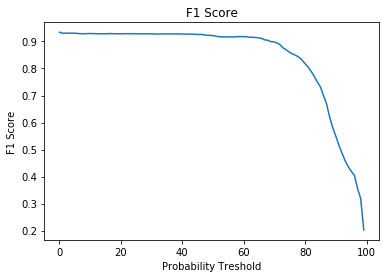

In [649]:
#f1 score plot 
probs = clf.predict_proba(X_test)
TPR_list, FPR_list, F1_score_list, MMC_score_list, results_table = f1_scores(probs, y_test)

plt.plot( np.linspace(0,1,100)*100, F1_score_list,)
plt.xlabel('Probability Treshold');
plt.ylabel('F1 Score')
plt.title('F1 Score');

In [653]:
#Changing probability treshhold
results_table['predicted'] = (results_table.public > 0.7)*1

accuracy_gbc = np.mean(results_table['predicted'] == y_test)
print ("gbc accuracy: ", accuracy_gbc)
pd.crosstab(results_table.real, results_table.predicted)
# results_table.groupby('real').agg({'public':['mean', 'std']})

gbc accuracy:  0.8175750834260289


predicted,0,1
real,,
0.0,21,90
1.0,74,714


#### Discriminant analysis

In [658]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [659]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

print ("Model accuracy: ", clf.score(X_test, y_test))
pd.crosstab(y_test, clf.predict(X_test))

Model accuracy:  0.8665183537263627


col_0,0.0,1.0
s_type,,
0.0,46,65
1.0,55,733


#### Kmeans neighbors

In [51]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors= 10)
clf.fit(X_train, y_train)

print ("Model accuracy: ", clf.score(X_test, y_test))
pd.crosstab(y_test, clf.predict(X_test))

Model accuracy:  0.8665183537263627


col_0,0.0,1.0
s_type,,
0.0,14,97
1.0,23,765


### Logistic regression - Binary model

In [19]:
mm.initialize()

Registering model step 'TOD_choice'
Registering model step 'auto_ownership'
Registering model step 'WLCM_gen_tt'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'
Registering model step 'Public_vs_private'


In [20]:
# Splitting train (70%) and test (30%) dataset
students_df.index.name = 'person_id'
X = students_df.drop(columns=['SAMPN', 'PERNO'])
school_level = pd.cut(X.mean9, bins =3, labels = ['bad', 'medium', 'good']).rename('school_level', inplace = True)


In [21]:
inc_dumies = pd.get_dummies(pd.cut(X.income, bins = [0,2,5,8,10], labels = ['hh_inc_under_25k', 
                                                'hh_inc_25_to_75k',
                                                'hh_inc_75_to_200k',
                                                'hh_inc_over_200k']))

X = pd.concat([X, school_level, inc_dumies], axis = 1)
train, test = train_test_split(X, test_size=0.3, random_state=42)

In [22]:
#Add train/test tables to Orca
orca.add_table('train_table', train)
orca.add_table('test_table', test);

# predicted = pd.Series(np.zeros(len(X_test)))
# orca.add_column('test_table', 's_type', predicted)

In [23]:
model_expression = 's_type ~ age_of_head   \
                    + recent_mover \
                    + income \
                    + mean9:income\
                    + persons  \
                    + np.divide(renters_10000,100000) \
                    + np.divide(sqft_unit_500_walk,1000) \
                    + np.divide(avg_rent_500_walk,1000) \
                    + np.divide(avg_income,10000) \
                    + np.divide(avg_income_gen_tt_CAR_30, 10000) \
                    + mean9:tenure \
                   '

model = BinaryLogitStep(tables = 'train_table', model_expression = model_expression)

In [24]:
model.fit()

Optimization terminated successfully.
         Current function value: 0.354159
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 s_type   No. Observations:                 2097
Model:                          Logit   Df Residuals:                     2085
Method:                           MLE   Df Model:                           11
Date:                Thu, 13 Feb 2020   Pseudo R-squ.:                  0.1299
Time:                        18:46:06   Log-Likelihood:                -742.67
converged:                       True   LL-Null:                       -853.59
Covariance Type:            nonrobust   LLR p-value:                 2.137e-41
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                   

In [442]:
model.name = 'Public_vs_private'
model.out_tables = 'test_table'
model.out_column = 's_type'
# model.out_filters = ['age <= 18', 'age>=4']
model.run()

In [28]:
orca.broadcast('nodessmall', 'persons', cast_index = True, onto_on = 'node_id_small')
orca.broadcast('nodeswalk', 'persons', cast_index = True, onto_on = 'node_id_walk')
orca.broadcast('zones', 'persons', cast_index = True, onto_on = 'zone_id_home')

In [29]:
@orca.column('nodessmall')
def mean9(public_schools_50):
    s = public_schools_50.mean9
    return s



In [30]:
model.name = 'Public_vs_private'
model.out_tables = ['persons', 'households', 'nodessmall', 'nodeswalk', 'zones']
model.out_column = 's_type'
model.out_filters = ['age <= 18', 'age>=4']
model.run()

ValueError: Could not find a target to merge table 5 onto

In [443]:
model.run()

testing = orca.get_table('test_table').to_frame()
pre = testing.s_type.rename('predicted')

accuracy_DCM = np.mean(pre == y_test)
print ("dcm accuracy: ", accuracy_DCM)
pd.crosstab( y_test, pre)#,normalize = 'index')

dcm accuracy:  0.7919911012235817


predicted,0.0,1.0
s_type,,
0.0,24,87
1.0,100,688


In [ ]:
# mm.register(model)

This will be needed for Simulation on the syntethic population. Not currently working because persons-nodes merge tables changes the shape of the persons table. 

In [ ]:
# #Orca modifications
# persons = orca.get_table('persons').to_frame()
# persons.rename(columns = {'zone_id_home':'zone_id'}, inplace = True)
# orca.add_table('persons', persons)

# nodessmall.index.rename('node_id_small', inplace= True)
# orca.add_table('nodessmall', nodessmall)

## TOD Model

In [ ]:
# This is a first approach to run my a 2-d estimation and random sample # 
# This is to estimate TOD for school arrival and departure time
from scipy import stats
m1 = np.random.normal(size=10000)
m2 = np.random.normal(scale=0.5, size=10000) + 56
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
kernel.resample(size = 2)

In [ ]:
schools.District.nunique()

In [ ]:
schools.columns